# Instalação dos modulos que não estão presentes nativamente no ambiente - Colab

# ALunos:
* Felipe Ferreira
* Ian Nunes

In [0]:
!pip3 install pydicom plotly scikit-image
!python -c "import skimage; print(skimage.__version__)"
!pip3 install pypng

     |████████████████████████████████| 7.1MB 4.1MB/s 
0.15.0
     |████████████████████████████████| 655kB 5.1MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67163 sha256=cfe438d222de896de65f1116791936a621ef49bcefd69bc27b70422ae6f6cd63
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


# import de todos os modulos usados para ler e segmentar as imagens 

In [0]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import argparse
import cv2
import numpy as np
import pydicom as dicom
import png
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

from google.colab.patches import cv2_imshow

# montando o google drive como repositorio de arquivos e iniciando os caminhos dos arquivos

In [0]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/My Drive/Doutorado /modvis/dicom_data"
output_path = working_path = "/content/drive/My Drive/Doutorado /modvis/work"
g = glob(data_path + '/*.dcm')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# essa função carrega todas as camadas de imagens, representadas pelos arquivos individuais na pasta "data_path" e retorna um array ordenado com os objetos DICOM

In [0]:
def load_scan(path):
  slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
  slices.sort(key = lambda x: int(x.InstanceNumber))
  try:
      slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
      slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
      
  for s in slices:
    s.SliceThickness = slice_thickness
      
  return slices

patient = load_scan(data_path)
id=str(patient[0].PatientID)

## funcao recebe um array com as camadas de informação DICOM e gera, a partir da radiodensidade, um array com todas as imagens sem os metadados


In [0]:
def get_pixels_hu(scans):
  image = np.stack([s.pixel_array for s in scans])
  # Convert to int16 (from sometimes int16), 
  # should be possible as values should always be low enough (<32k)
  image = image.astype(np.int16)
  # Set outside-of-scan pixels to 1
  # The intercept is usually -1024, so air is approximately 0
  image[image == -2000] = 0
    
  # Convert to Hounsfield units (HU)
  intercept = scans[0].RescaleIntercept
  slope = scans[0].RescaleSlope
    
  if slope != 1:
    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)
        
  image += np.int16(intercept)
    
  return np.array(image, dtype=np.int16)

imgs = get_pixels_hu(patient)



(30, 512, 428)


# salva o array com todas as imagens para uso posterior

In [0]:
file_used = output_path + "/fullimages_"+(str(id))+".npy"
np.save(file_used  , imgs)
print(file_used)

/content/drive/My Drive/Doutorado /modvis/work/fullimages_0019730464.npy


# normalizando a imagem

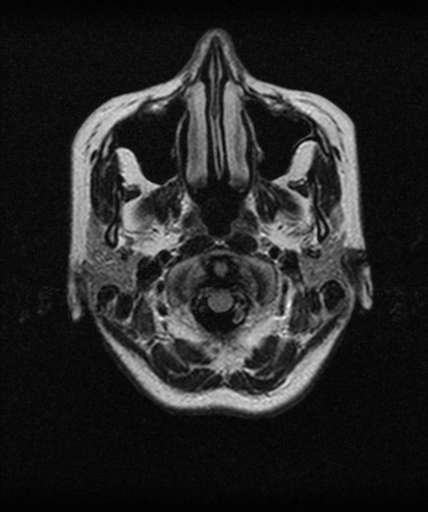

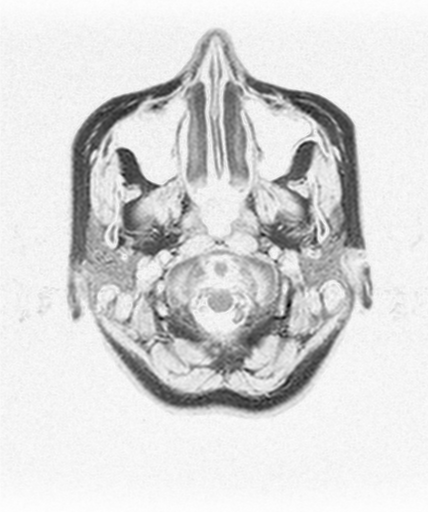

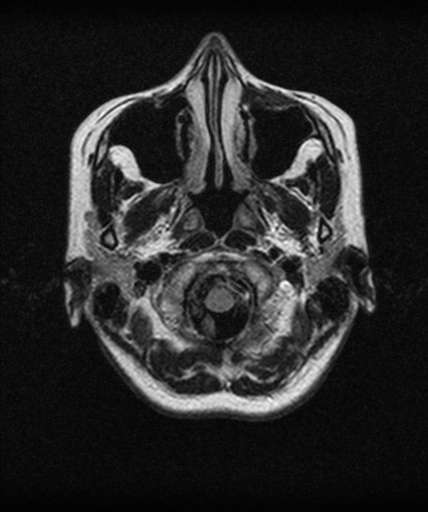

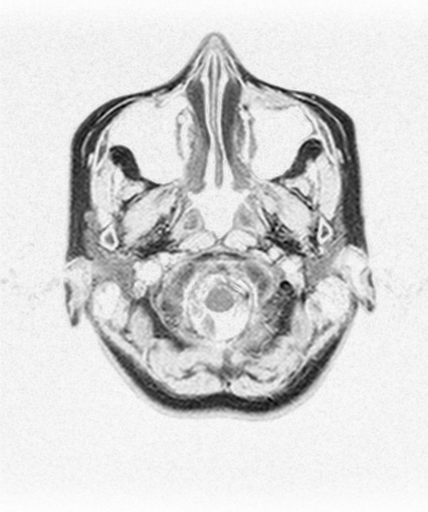

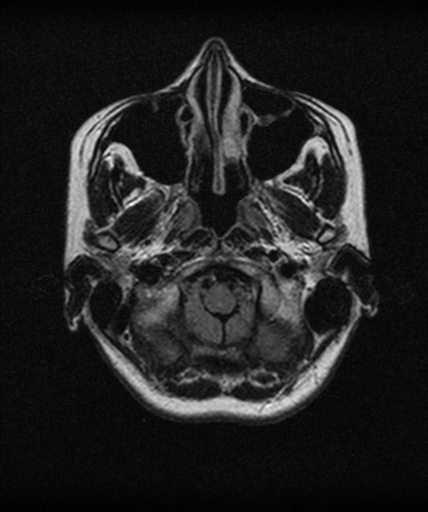

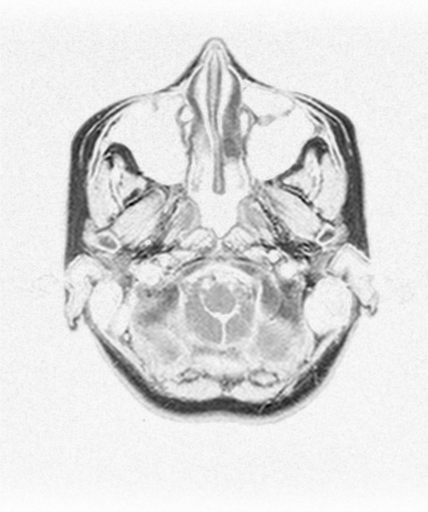

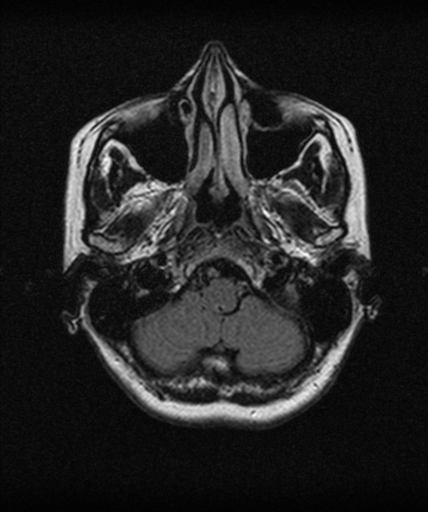

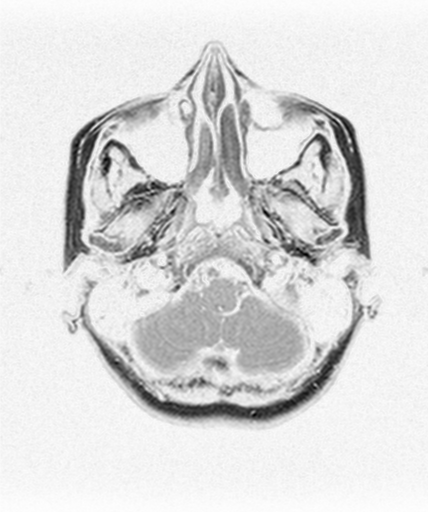

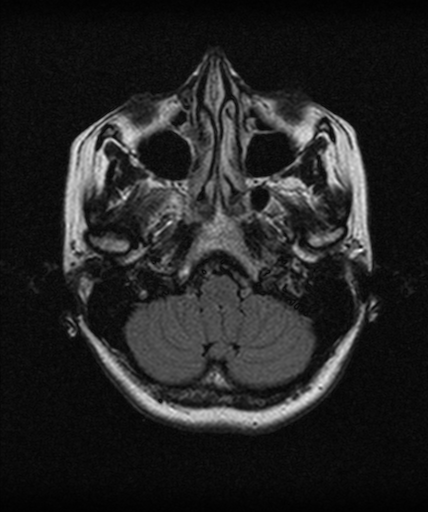

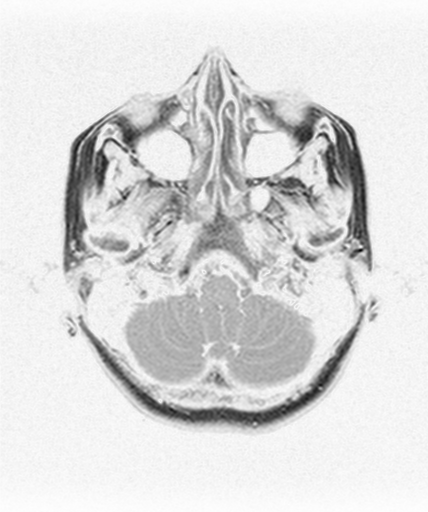

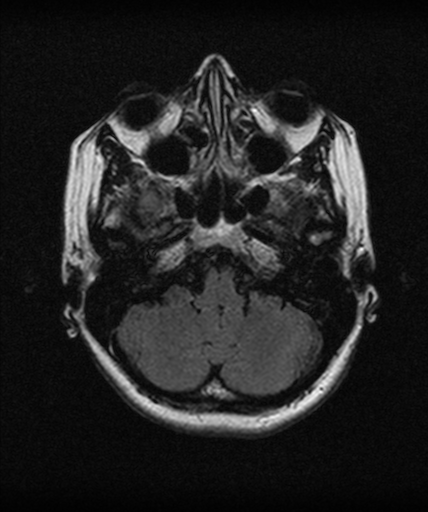

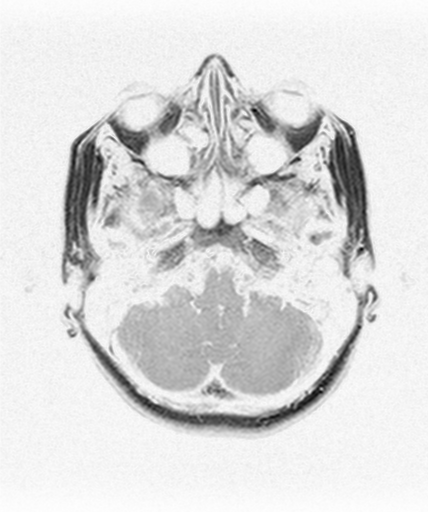

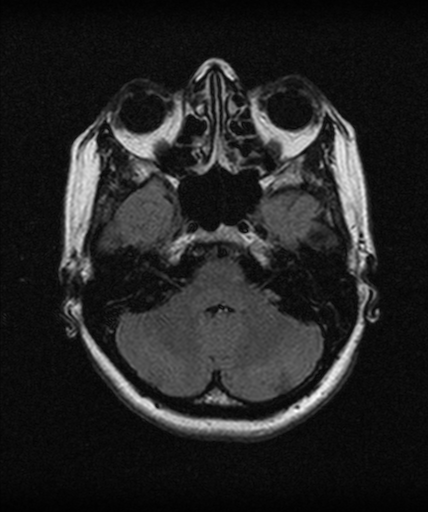

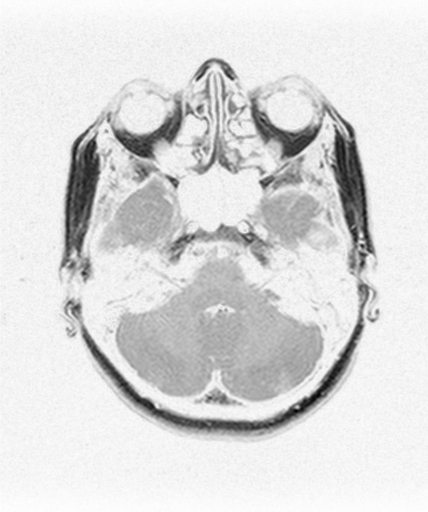

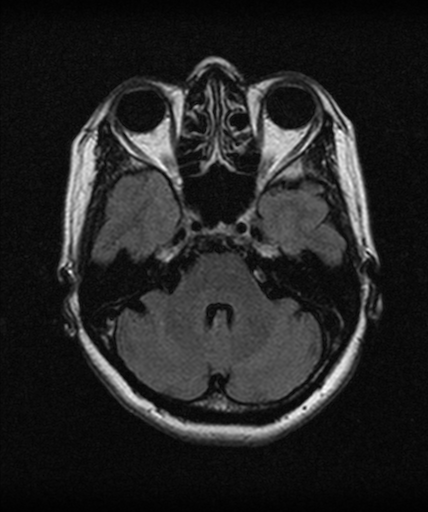

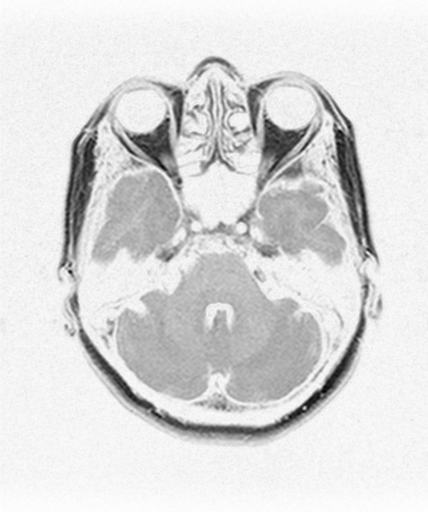

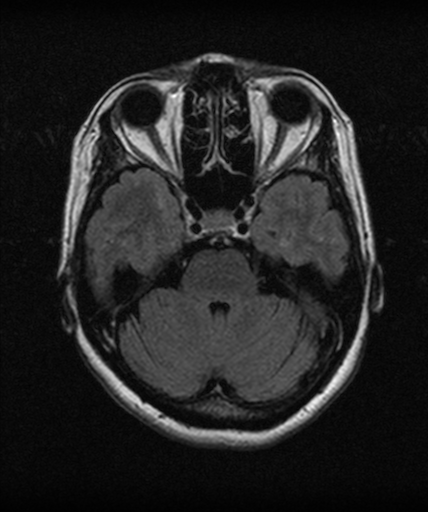

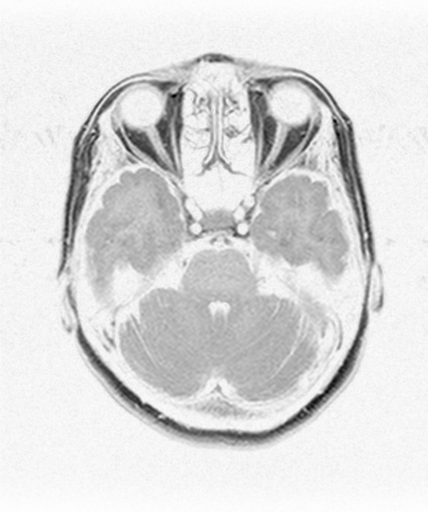

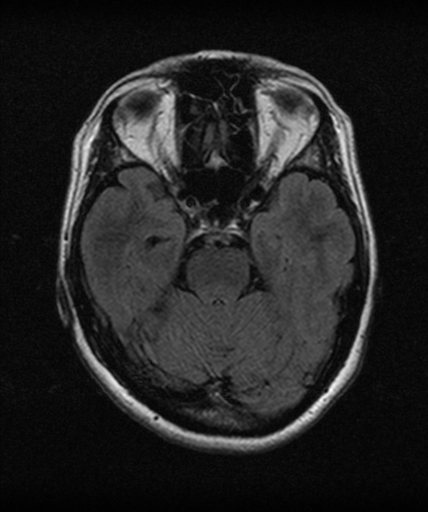

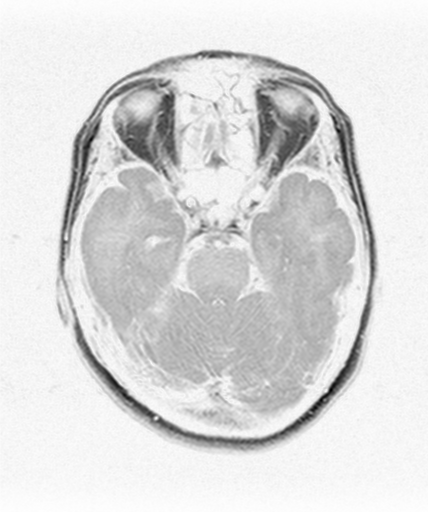

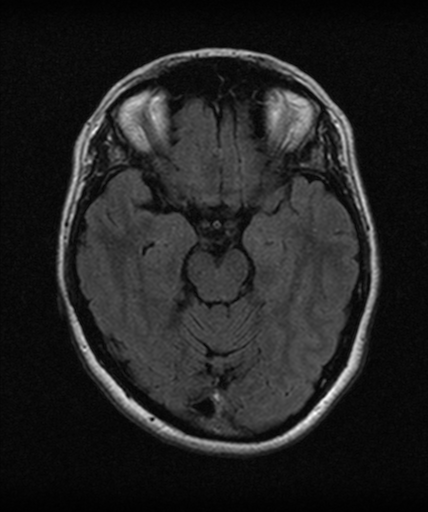

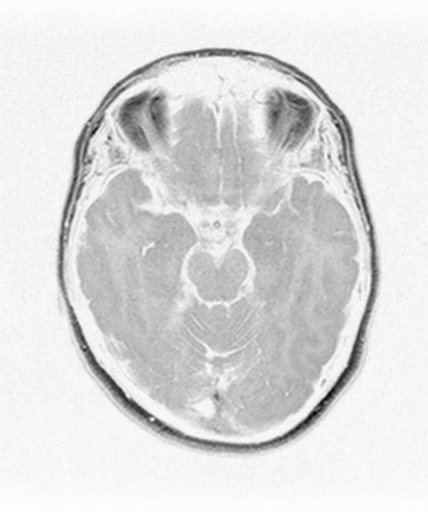

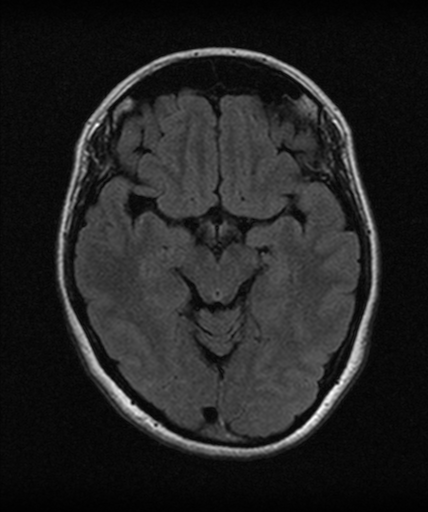

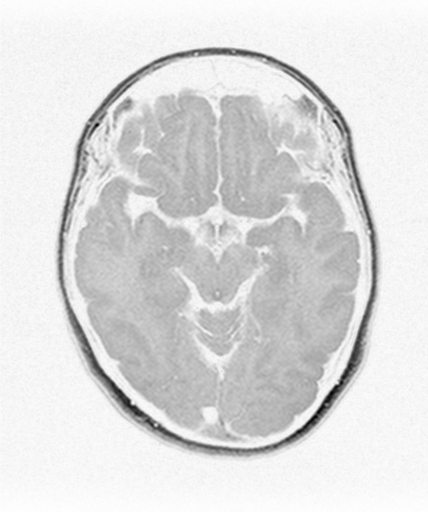

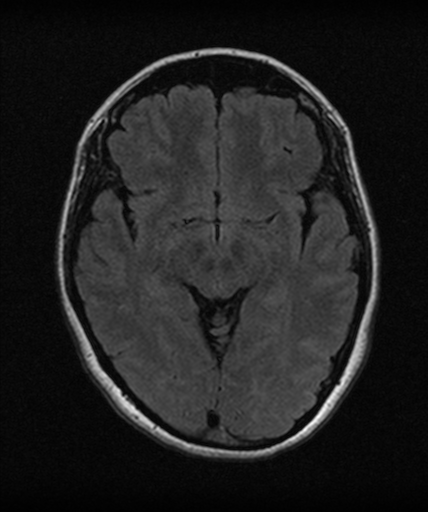

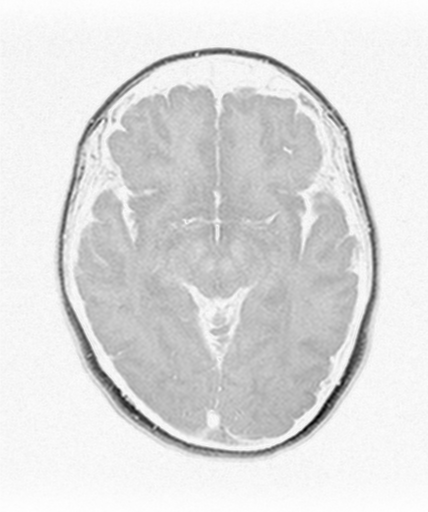

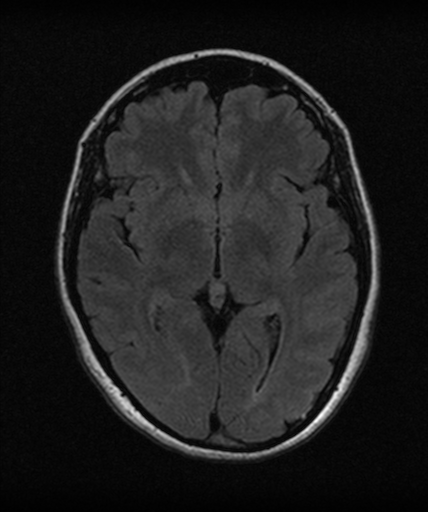

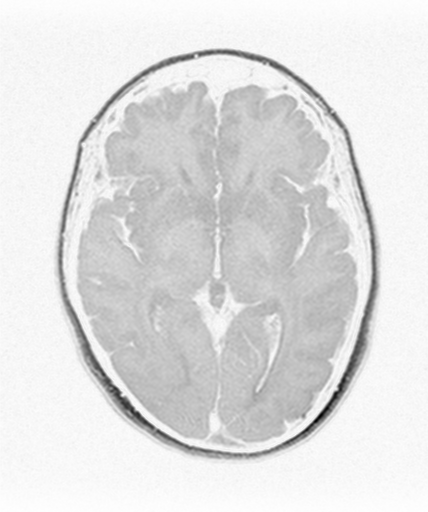

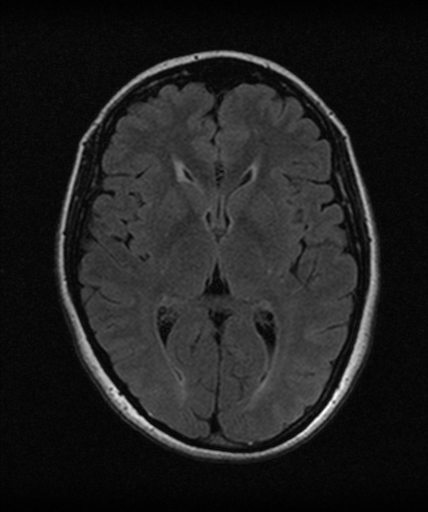

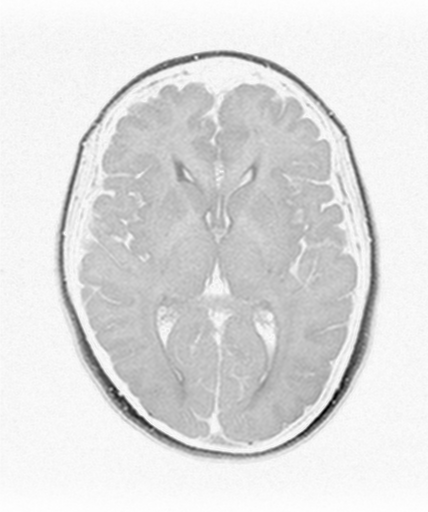

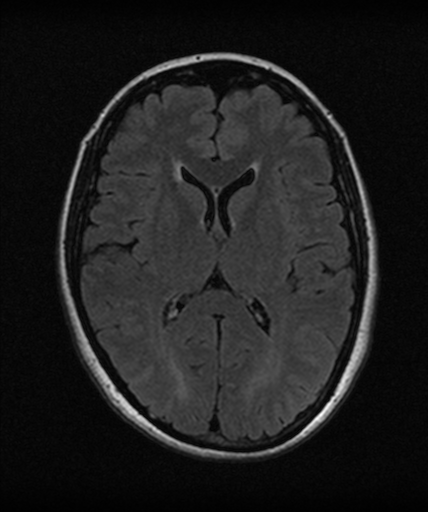

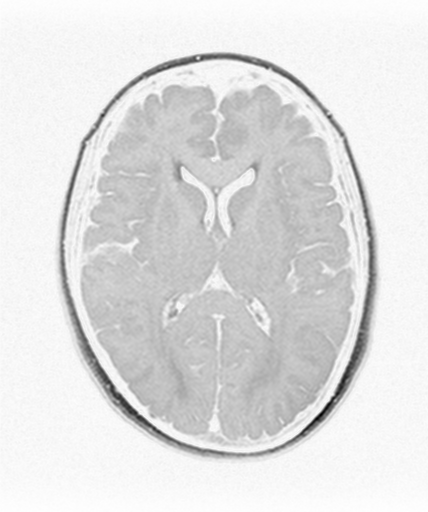

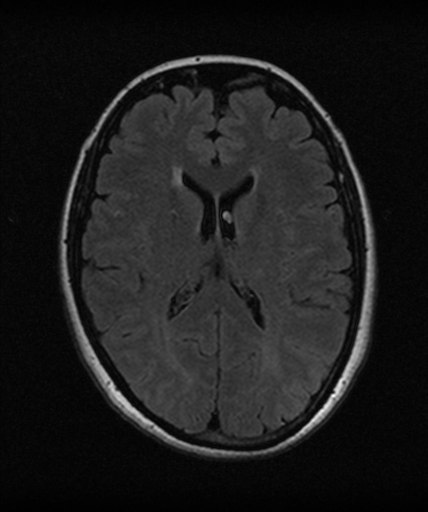

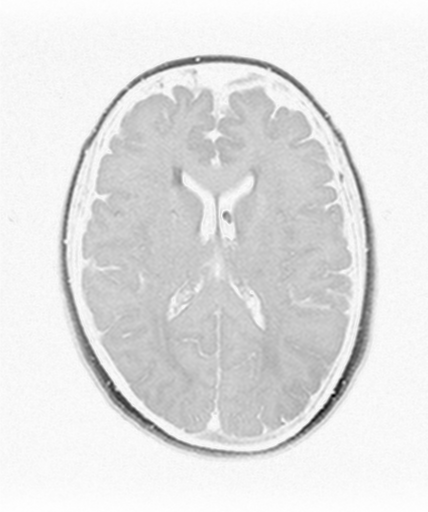

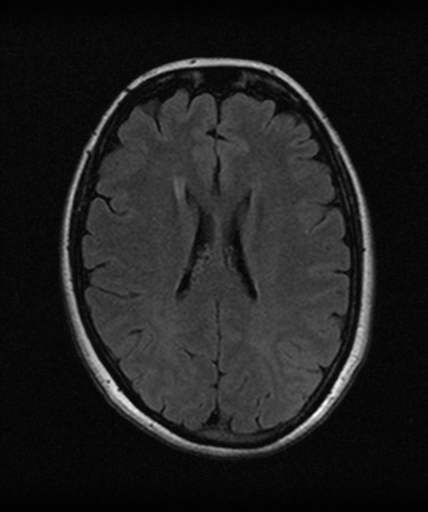

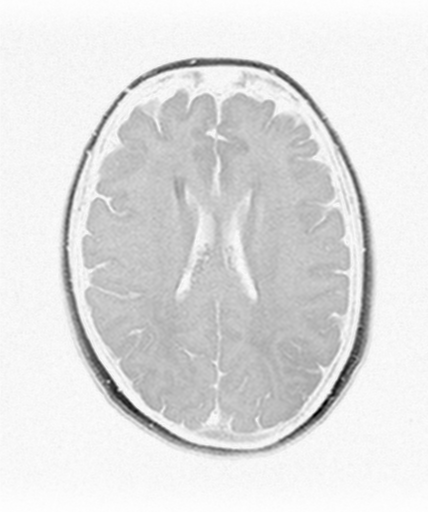

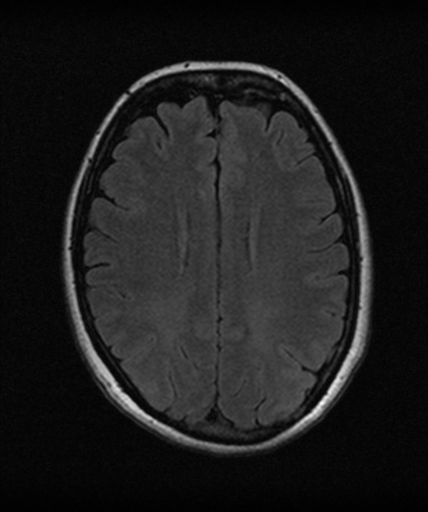

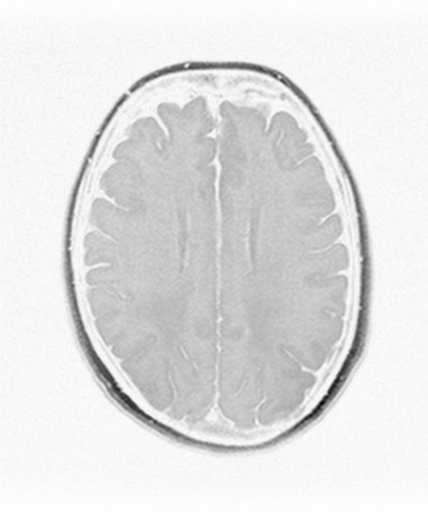

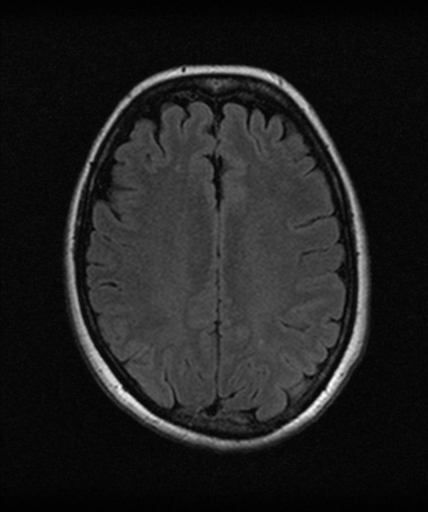

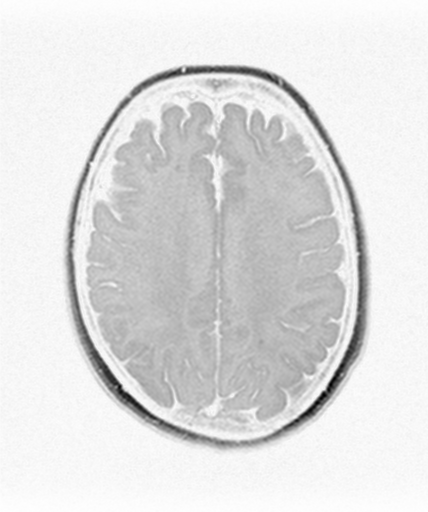

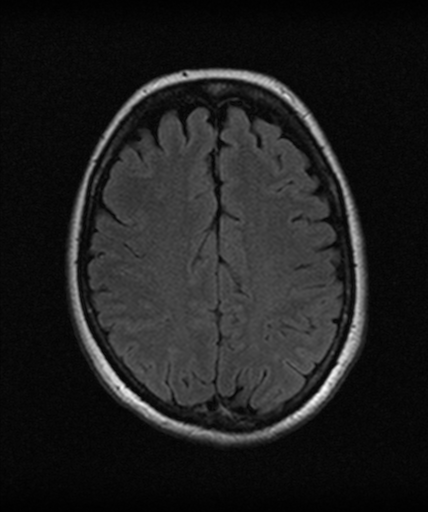

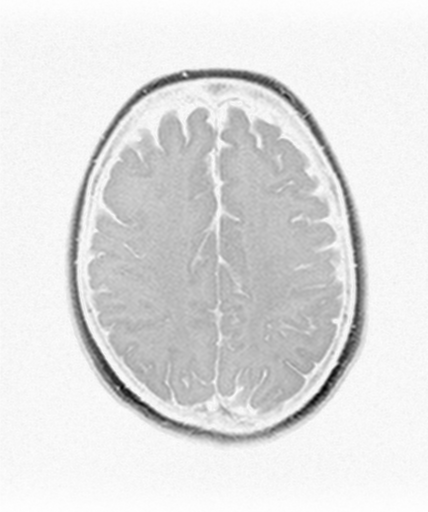

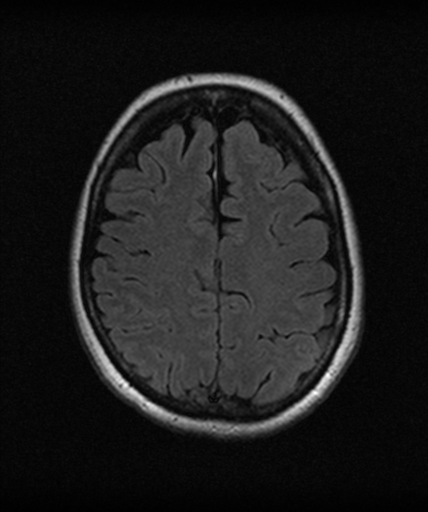

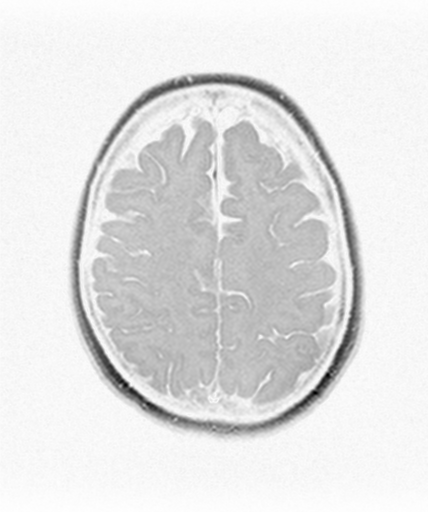

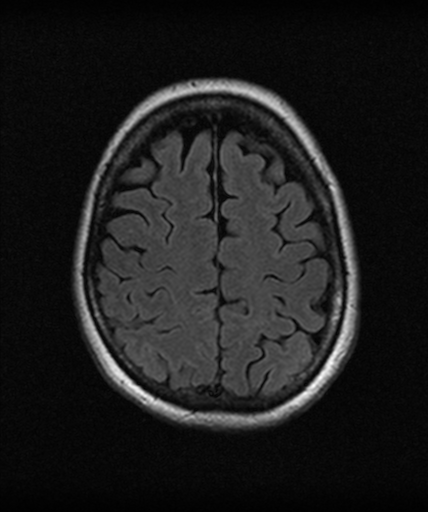

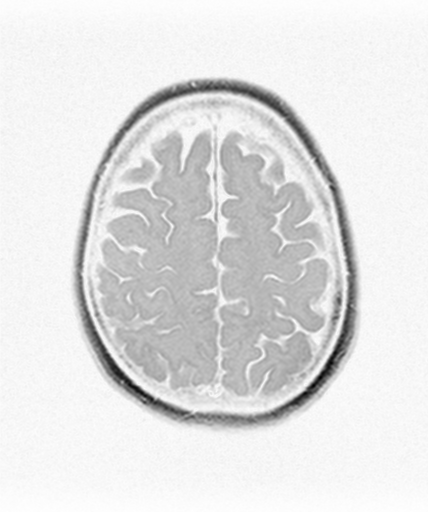

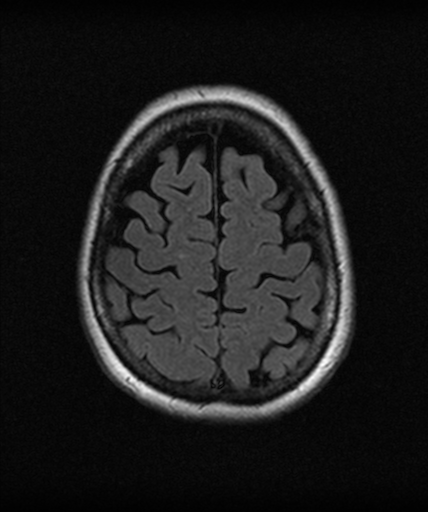

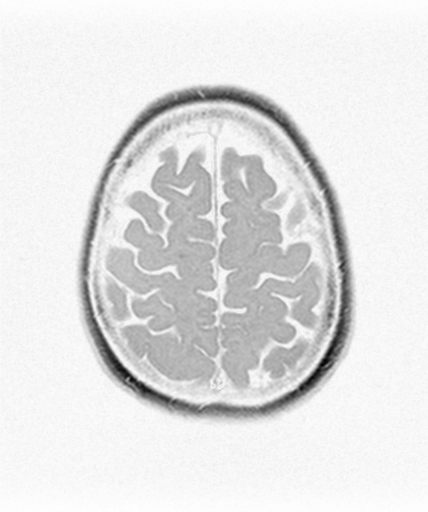

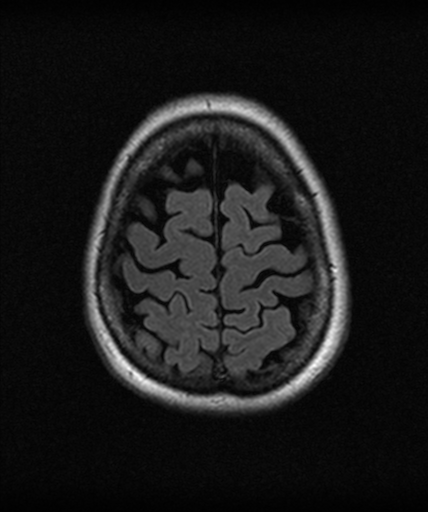

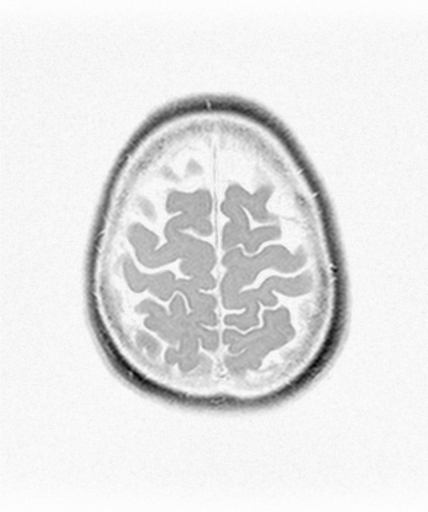

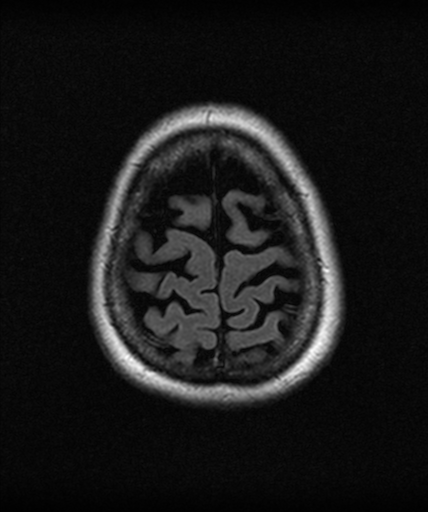

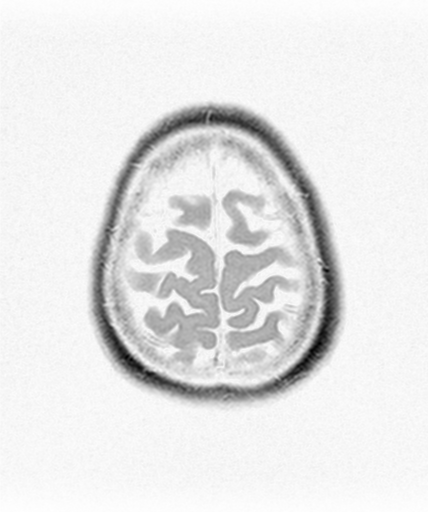

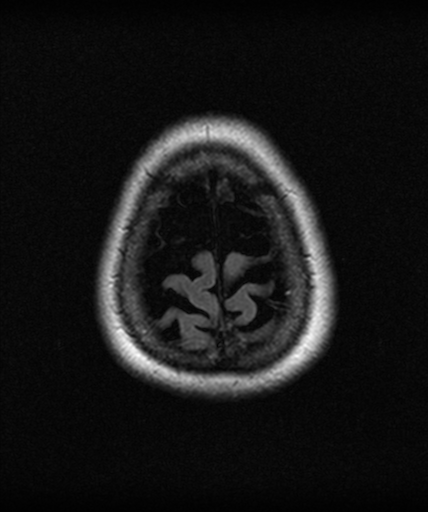

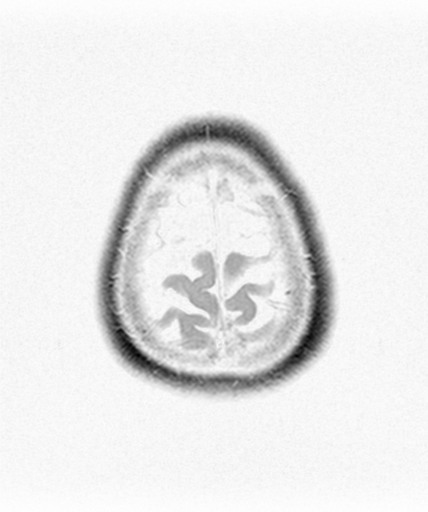

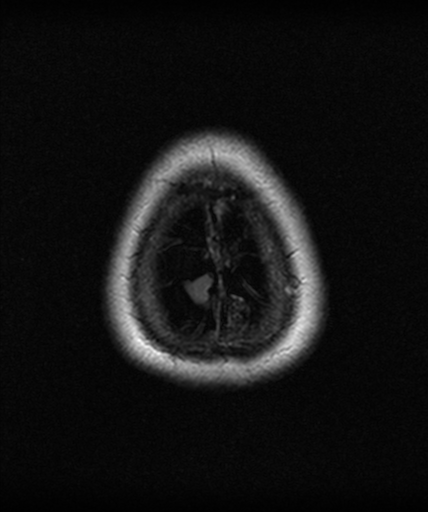

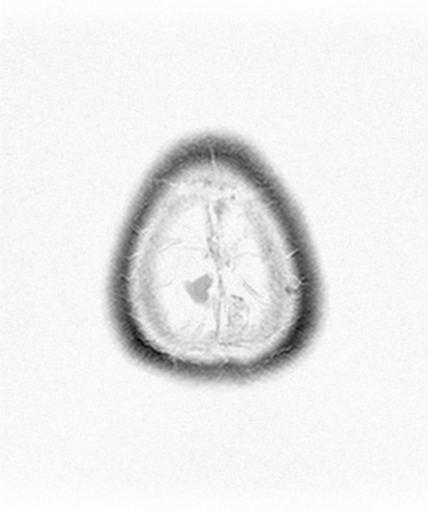

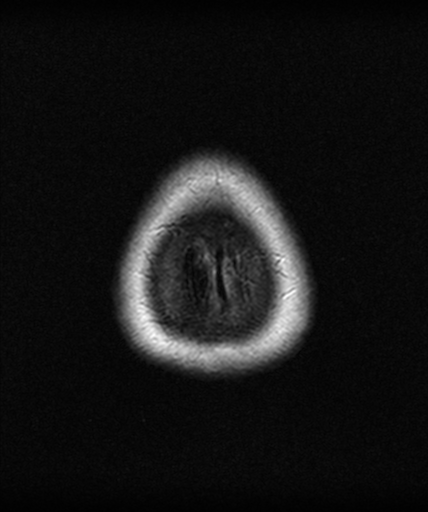

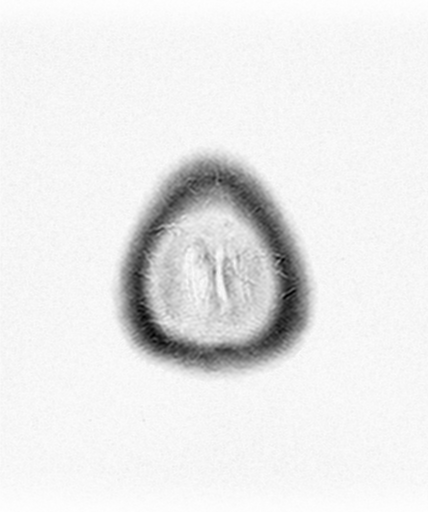

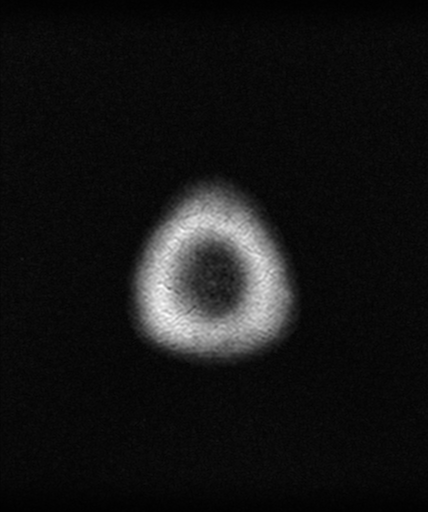

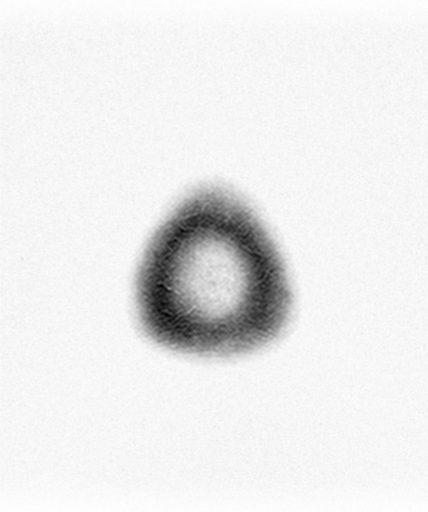

In [0]:
image_2d_scaled=[]

for i in range(0,len(imgs)):
  image_2d = imgs[i].astype(float)

  # Rescaling grey scale between 0-255
  image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
  cv2.imwrite(os.path.join(output_path, str(patient[i].PatientID)+"_"+str(patient[i].InstanceNumber)+"_.jpg"), cv2.bitwise_not(np.uint8(image_2d_scaled) ))
  cv2.imwrite(os.path.join(output_path, str(patient[i].PatientID)+"_"+str(patient[i].InstanceNumber)+".jpg"), np.uint8(image_2d_scaled))

  cv2_imshow(np.uint8(image_2d_scaled))
  cv2_imshow(cv2.bitwise_not(np.uint8(image_2d_scaled)))


# funcao auxiliar que converte os arquivos DICOM diretamente para imagens png

In [0]:
def dicom2png(source_folder, output_folder):
    list_of_files = os.listdir(source_folder)
    for file in list_of_files:
        
        try:    
            ds = dicom.dcmread(os.path.join(source_folder,file))
            shape = ds.pixel_array.shape

            # Convert to float to avoid overflow or underflow losses.
            image_2d = ds.pixel_array.astype(float)

            # Rescaling grey scale between 0-255
            image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0

            # Convert to uint
            image_2d_scaled = np.uint8(image_2d_scaled)

            # Write the PNG file
            with open(os.path.join(output_folder,file.replace(".dcm",".png")) , 'wb') as png_file:
                w = png.Writer(shape[1], shape[0])
                w.write(png_file, image_2d_scaled)
        except:
            print('Could not convert: ', file)


dicom2png("/content/drive/My Drive/Doutorado /modvis/dicom_data/", output_path)

# carrega o arquivo com todas as imagens

In [0]:
imgs_to_process = np.load(file_used).astype(np.float64) 

# apresenta o histograma com a radiodensidade

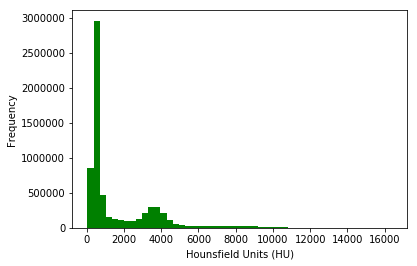

In [0]:
plt.hist(imgs_to_process.flatten(), bins=50, color='g')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# exibe em um grid as imagens DICOM

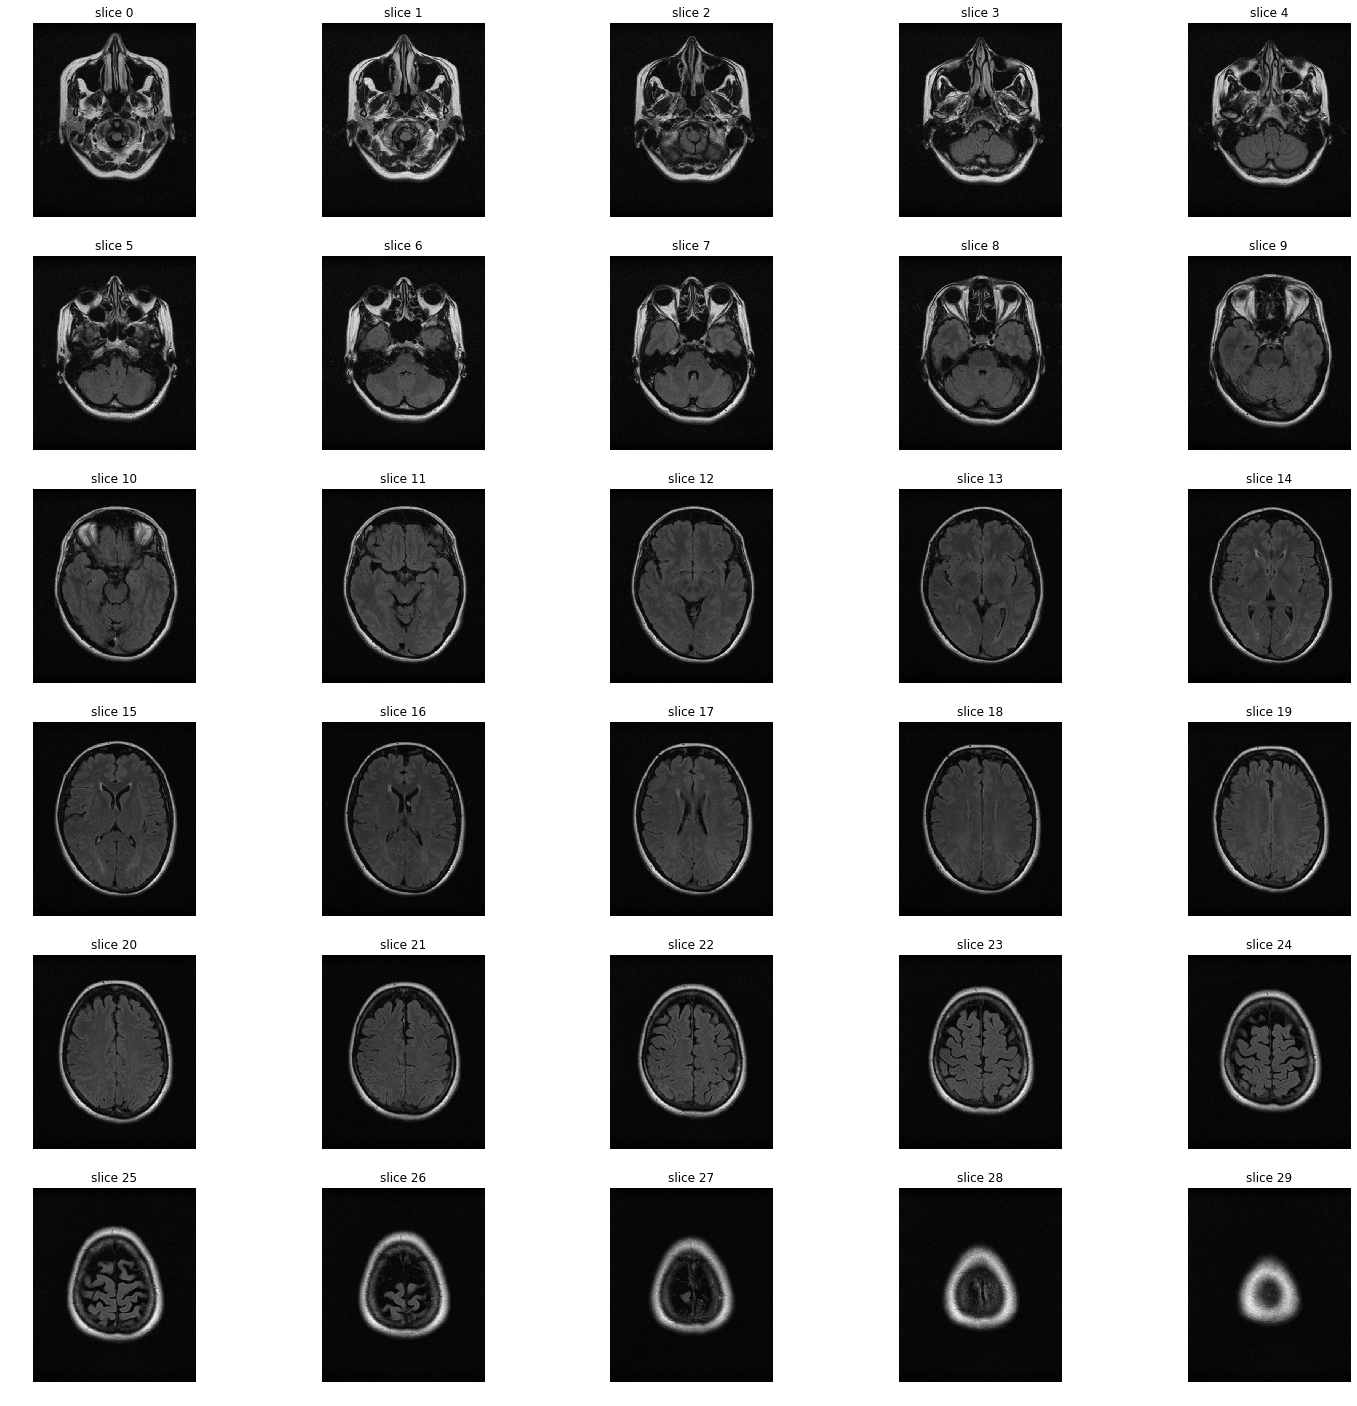

In [0]:
def sample_stack(stack, rows=6):
  stacklen = len(stack)
  itemsperrow=int(stacklen/rows)
  fig,ax = plt.subplots(rows,itemsperrow,figsize=[25,25])
  for i in range(rows):
    for j in range(itemsperrow):
      ind = i*itemsperrow + j
      ax[i,j].set_title('slice %d' % ind)
      ax[i,j].imshow(stack[ind],cmap='gray')
      ax[i,j].axis('off')
  plt.show()

sample_stack(imgs_to_process)

In [0]:
print ("Slice Thickness: %f" % patient[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 4.931271
Pixel Spacing (row, col): (0.468700, 0.468700) 


# lista os arquivos de imagem salvos anteriormente

In [0]:
list_of_files = os.listdir(output_path)
# containsPath = lambda path, part: path.find(part) > 0 
# list(filter(containsPath, list_of_files, "jpg"))
list_of_files = [x for x in list_of_files if x.find("jpg") > 0 and x.find(id) >= 0]
# print (list_of_files)

# segmenta usando o SLIC as imagens e salva em arquivos para todas as configuracoes, assim como salva o arquivo com os segmentos

In [0]:
# loop over the number of segments
for numSegments in (100, 200, 300, 400):
  for fileName in (list_of_files):
    fPath = os.path.join(output_path, fileName)
    image =io.imread(fPath)
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, compactness=0.08)

    # show the output of SLIC
    boundaries = mark_boundaries(image, segments, color=(1,0.6,0.5))

    image_2d = boundaries
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    image_2d_scaled = np.uint8(image_2d_scaled)

    np.save(fPath.replace(".jpg","_"+str(numSegments)+"_segments"),segments)
    print (fPath.replace(".jpg","_"+str(numSegments)+"_segments"))

    cv2.imwrite(fPath.replace(".jpg","_"+str(numSegments)+".jpg"), image_2d_scaled)
    print(fPath.replace(".jpg","_"+str(numSegments)+".jpg"))

    # cv2_imshow(image_2d_scaled)


/content/drive/My Drive/Doutorado /modvis/work/0019730464_1__100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_1__100.jpg
/content/drive/My Drive/Doutorado /modvis/work/0019730464_1_100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_1_100.jpg
/content/drive/My Drive/Doutorado /modvis/work/0019730464_2__100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_2__100.jpg
/content/drive/My Drive/Doutorado /modvis/work/0019730464_2_100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_2_100.jpg
/content/drive/My Drive/Doutorado /modvis/work/0019730464_3__100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_3__100.jpg
/content/drive/My Drive/Doutorado /modvis/work/0019730464_3_100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_3_100.jpg
/content/drive/My Drive/Doutorado /modvis/work/0019730464_4__100_segments
/content/drive/My Drive/Doutorado /modvis/work/0019730464_4__100.jpg
/cont